#### This script will analyze the distribution of bounding box size of objects in a Object detection dataset where annotations are in pascal VOC format (i.e an .xml file for each images)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import csv
import xml.etree.ElementTree as ET
import fnmatch
from sklearn import preprocessing

## Convert all the annotations into CSV for analysis
Read all Annotations and store in bufffer

In [2]:
# Choose train2014 or val2014         
# This is specifically for coco dataset because file name ccontains the information that image is in train set
# or val set and we search this string in file name to load the annotations
img_set = 'train2014'

# Path where all annotations are stored
path = 'Annotations/' + '*.xml' 
files = glob.glob(path)

# empty list to store all annotations 
result = []

Now loop thorgh every file and store annotations into 2D list (#rows = #total number of objects)

And finally write all the information into a single CSV file

In [3]:
print 'Generating List............'

search_str = '*' + img_set + '*'
#Iterating through each file
for infile in files:
    if fnmatch.fnmatch(infile, search_str):
        
        tree = ET.parse(infile)
        root = tree.getroot()
        
        #Extract Name, Width and Height of Image
        width = root.find('size').find('width').text
        height = root.find('size').find('height').text
        filename = root.find('filename').text
                
        #Iterate through all GT bounding Box in Data
        
        for object in root.findall('object'):
            row = []
            #Append Image Name, Image Width and Image Height
            row.extend([filename, width, height])
            
            #Append Object name
            name = object.find('name').text
            row.append(name)
            
            #Append bounding box information
            bndbox = object.find('bndbox')
            x1 = bndbox.find('xmin').text
            y1 = bndbox.find('ymin').text
            x2 = bndbox.find('xmax').text
            y2 = bndbox.find('ymax').text
            #print 'x1: ' + x1 + ' y1: ' + y1 + ' x2: ' + x2 + ' y2: ' + y2
            row.append(x1)
            row.append(y1)
            row.append(x2)
            row.append(y2)
            
            # bbox width and height
            row.append(abs(int(x2) - int(x1)))
            row.append(abs(int(y2) - int(y1)))
           
            result.append(row)
            
print 'Generation completed'
print 'Saving the annotation into CSV for convinence'

# Saving the information in a csv file
fileName = 'log_files/' + img_set + '.csv'
with open(fileName, "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Img_Id','Img_Width','Img_Height','Object','x1','y1','x2','y2','bbox_width','bbox_height'])
    writer.writerows(result)
    
print 'Coversion Completed.'

Generating List............
Generation completed
Saving the annotation into CSV for convinence
Coversion Completed.


## load the CSV and perform analysis on data 

load the data into dataframe and drop unnecessary columns.
Calculate the % of area occupied by bounding nox wrt Image

In [4]:
# load csv into pandas dataframe
data = pd.read_csv(fileName)
drop_list = ['Img_Id', 'x1', 'x2', 'y1', 'y2']
data.drop(drop_list, inplace=True, axis=1)
# Calculate Image Area
data['Img_Area'] = data.Img_Width * data.Img_Height
# Calculate Bounding Box Area
data['bbox_Area'] = data.bbox_width * data.bbox_height
# Calculate the proportion of image occupied
data['area_occ'] = data['bbox_Area'].div(data['Img_Area']) * 100
print data.shape
data.head(5)

(19344, 8)


,Img_Width,Img_Height,Object,bbox_width,bbox_height,Img_Area,bbox_Area,area_occ
0,480,640,toilet_openToilet,413,459,307200,189567,61.708008
1,552,640,umbrella_openUmbrella,166,49,353280,8134,2.302423
2,552,640,umbrella_openUmbrella,157,43,353280,6751,1.910949
3,552,640,umbrella_openUmbrella,113,37,353280,4181,1.183481
4,552,640,umbrella_openUmbrella,73,31,353280,2263,0.640568


Now Divide the objects into bins according to the proportion of Image they occupied to analyze the distribution in complete dataset

In [5]:
# Describe the bins
bins = [0, 5, 10, 20, 30, 50, 75, 100]
bin_labels = ['5', '10', '20', '30', '50', '75', '100']
# Binning the objects accoding to the proportion they occupied
data['bin_area_occ'] = pd.cut(data['area_occ'], bins, labels=bin_labels)
# Counting the frequencies in each bin
bin_count = pd.value_counts(data['bin_area_occ']).tolist()
bin_count = [int(i) for i in bin_count]
print bin_count

[11673, 2695, 2320, 974, 892, 485, 305]


Plot the stats of complete dataset to see the distribution

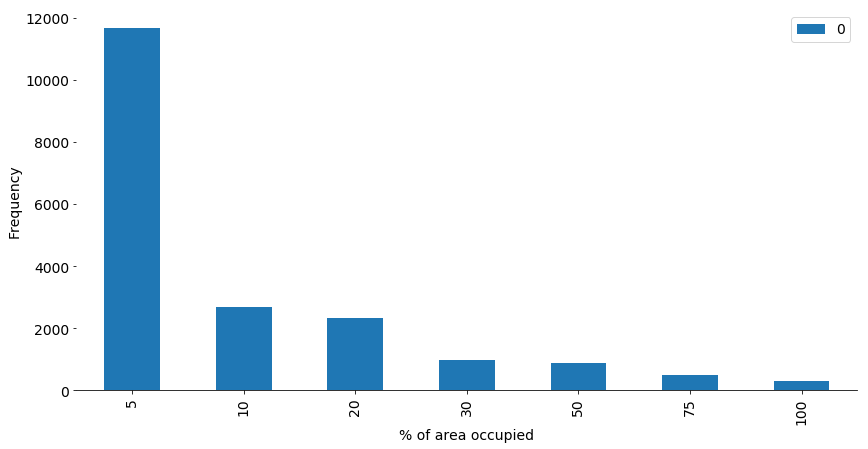

In [6]:
# Plot size to 14" x 7"
matplotlib.rc('figure', figsize = (14, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', left = False, bottom = True, top = False, right = False)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

X = range(0,len(bin_labels))
df = pd.DataFrame(bin_count, index=X)
df.plot.bar()
plt.ylabel('Frequency')
plt.xlabel('% of area occupied')
plt.xticks(X, bin_labels)
plt.show()

Grouping Data according to object categories and 
calculating the frequency of objects in each bin which is binned according to
the proportion they occupied w.r.t Image

In [7]:
# Grouping Data according to object categories
grouped_data = data.groupby(['Object'])
norm_freq = {}
freq = {}
# Calculating the frequency and normalized frequency in each group
for name,group in grouped_data:
     norm_freq[name] = pd.value_counts(group['bin_area_occ'], normalize=True).tolist()
     freq[name] = pd.value_counts(group['bin_area_occ']).tolist()
df = pd.DataFrame(norm_freq, index=X)
# Multiplying all values by 100 to express it in %
df.loc[:,:] *= 100
df = df.round(1)
df.head(10)

,laptop_closedLaptop,laptop_openLaptop,scissors_closedScissor,scissors_openScissor,suitcase_closedSuitcase,suitcase_openSuitcase,toilet_closedToilet,toilet_openToilet,umbrella_closedUmbrella,umbrella_openUmbrella
0,66.9,40.4,67.4,45.1,68.8,21.3,36.4,31.8,83.3,73.9
1,13.1,16.7,13.2,14.9,13.8,18.9,26.0,23.3,7.9,10.1
2,10.4,16.6,11.8,14.3,8.9,16.6,24.1,20.7,6.3,7.6
3,4.5,9.5,3.8,12.1,3.9,16.3,6.3,8.6,1.5,3.3
4,2.5,8.9,2.8,5.7,2.6,10.0,4.6,8.2,0.5,2.8
5,1.5,5.3,0.7,5.4,1.2,9.0,1.9,4.5,0.3,1.4
6,1.0,2.6,0.4,2.5,0.7,8.0,0.7,3.0,0.2,0.9


Plotting the proportion of instances in each group against the proportion they occupy in the image which is binned in diffrent range 

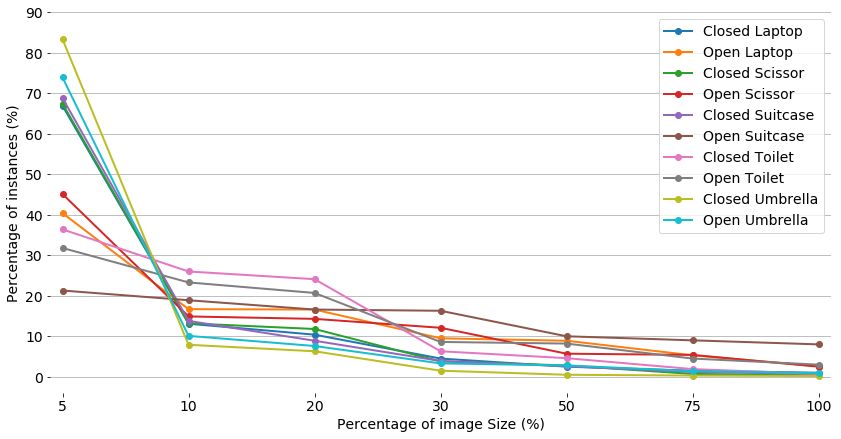

In [8]:
# for setting ticks along y axis
Y = range(0,100, 10)
# Labels for legend
legend_label = ['Closed Laptop', 'Open Laptop', 'Closed Scissor', 'Open Scissor',
               'Closed Suitcase', 'Open Suitcase', 'Closed Toilet', 'Open Toilet',
               'Closed Umbrella', 'Open Umbrella']
df.plot(linewidth=2.0, marker='o')
plt.ylabel('Percentage of instances (%)')
plt.xlabel('Percentage of image Size (%)')
plt.xticks(X, bin_labels)
plt.yticks(Y)
ax = plt.axes()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# horizontal grids
ax.yaxis.grid(True)
# Adding small margin on left and right
ax.set_xlim(ax.get_xlim()[0] - 0.1, ax.get_xlim()[1] + 0.1)
# Adding Legend
ax.legend(legend_label)
plt.show()
#plt.savefig('log_files/train_bbox_size.png', transparent=True, bbox_inches='tight')